# pkgexplore

In [1]:
%%script echo skipping

import pkgutil
from collections import defaultdict
from importlib import import_module
import attr
import inspect
from typing import Dict, Set, List, Tuple, Pattern
import re
Module = attr.__class__

@attr.s
class PkgExplore:
    pkg: Module = attr.ib()
    _sym2mod: Dict[str, Set[Module]] = attr.ib(init=False, default=defaultdict(lambda: set()))
    _sym2orig: Dict[str, Set[Module]] = attr.ib(init=False, default=defaultdict(lambda: set()))
    _modsymcnt: Dict[Module, int] = attr.ib(init=False, default={})
    _modorigcnt: Dict[Module, int] = attr.ib(init=False, default=defaultdict(lambda: 0))

    def __attrs_post_init__(self):
        self.build_index()

    def build_index(self):
        for modinfo in pkgutil.walk_packages(self.pkg.__path__, self.pkg.__name__ + '.', onerror=lambda _: None):
            if modinfo.ispkg:
                continue
            try:
                mod = import_module(modinfo.name)
            except ModuleNotFoundError as e:
                print(f'Error importing {modinfo.name}: {e}')
            syms = [s for s in dir(mod) if not s.startswith('_')]
            self._modsymcnt[mod] = len(syms) 
            for sym in syms:
                self._sym2mod[sym].add(mod)
                orig_mod = inspect.getmodule(getattr(mod, sym))
                if orig_mod:
                    self._sym2orig[sym].add(orig_mod)

        for sym, origs in self._sym2orig.items():
            for o in origs:
                self._modorigcnt[o] += 1

    def query(self, sym: str) -> Tuple[List[str], List[str]]:
        found = self._sym2mod[sym]
        origs = self._sym2orig[sym]
        imps = found - origs
        
        # has_orig, num_orig, total_syms, mod_parts
        keyfunc = lambda mod: (self._modorigcnt[mod] > 0, self._modorigcnt[mod], self._modsymcnt[mod], len(mod.__name__.split('.')))   
        
        sorted_imps = sorted(imps, key=keyfunc)
        return [mod.__name__ for mod in origs], [mod.__name__ for mod in sorted_imps]

    def query_re(self, pat: Pattern) -> Dict[str, Tuple[List[str], List[str]]]:
        matching = (sym for sym in self._sym2mod.keys() if pat.search(sym))
        return {sym:self.query(sym) for sym in matching}
    
import fastai2
ff = PkgExplore(fastai2)


ff.query('dice')


skipping


# Setup

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [3]:
from fastai2.imports import *
from fastai2.torch_core import *
from fastai2.learner import *

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [4]:
# !pip install colorcet

import colorcet as cc
import matplotlib as mp
glasbey_cm = mp.colors.ListedColormap(['black'] + cc.glasbey_dark[:95])

In [5]:
from PIL import Image
def show_npimg(npimg, dpi=96, cmap='gray', fig_ax=None, figsize=None):
    if fig_ax is None:        
        figsize = (npimg.shape[0]/dpi, npimg.shape[1]/dpi) if figsize is None else figsize
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    else:
        fig, ax = fig_ax

    fig.subplots_adjust(left=0,right=1,bottom=0,top=0.95,wspace=0.025,hspace=0.025)
    ax.set_axis_off()
    ax.imshow(npimg, cmap=cmap, interpolation='none') 

def show_img(img: Image, *args, **kwargs):
    show_npimg(np.array(img), *args, **kwargs)

# load data

In [6]:
from pathlib import Path
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.data.all import *
from typing import Literal, Tuple

In [7]:
gen_path = Path('./outputs')
img_path = gen_path / 'images'
mask_path = gen_path / 'masks'

In [8]:
fnames = get_image_files(img_path)
fnames[:3], fnames[0].stem

((#3) [Path('outputs/images/7292.png'),Path('outputs/images/8353.png'),Path('outputs/images/3687.png')],
 '7292')

In [9]:
masknames = get_files(mask_path)
masknames[:3]

(#3) [Path('outputs/masks/7292.png'),Path('outputs/masks/8353.png'),Path('outputs/masks/3687.png')]

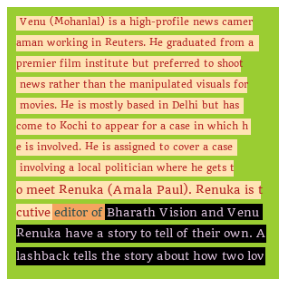

In [10]:
PILImage.create(fnames[0]).show(figsize=(5,5))

(300, 300)

Vocab size: 95


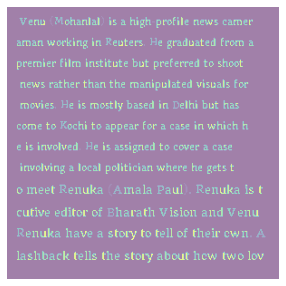

In [11]:
get_y_fn = lambda f: mask_path / f.name
mask = PILMask.create(get_y_fn(fnames[0]))
mask.show(figsize=(5,5), cmap='viridis')

src_size = mask.shape
src_size

bs = 8

codes = ['Bgd'] + [chr(i) for i in range(33, 127)] 
print("Vocab size:", len(codes))

# visualize

In [12]:
# !pip install graphviz
# !sudo apt-get install graphviz

# import hiddenlayer as hl
# tfms = [ hl.transforms.Fold('Shape > Gather > Unsqueeze', 'Unsq2')] + hl.transforms.SIMPLICITY_TRANSFORMS + [
#         hl.transforms.Fold('ConvBnRelu > ConvBn > Add', 'ConvBnRelu2Add'), 
#         hl.transforms.Fold('ConvBnRelu2Add > Relu', 'ConvBnRelu2AddRelu'),
#         hl.transforms.Prune('Constant'),
#         #hl.transforms.Prune('Cast'),
#         #hl.transforms.Prune('Concat'),
#         #hl.transforms.Prune('Shape'),
#         hl.transforms.Fold('BatchNorm > Concat > Relu', 'BnConcatRelu'),
#         hl.transforms.Fold('Reshape > Transpose > Reshape', 'ReshapeTransposeReshape'),
#         hl.transforms.Fold('Shape > Slice > Cast > Div > Concat > Upsample', 'Upsample2'),

#         hl.transforms.FoldDuplicates(),
#     ]
# ht = hl.build_graph(learn.model, torch.zeros(tuple(b[0].shape)).cuda(), transforms=tfms)


# ht

# Define Learner

In [13]:
def pixel_acc(input, target):
    return (input.argmax(dim=1) == target.squeeze(1)).float().mean()



In [14]:
%%script echo tensor indexing

y = torch.arange(35).view(5, 7)
y

# use as [xs, ys]
y[tensor([0, 2, 4]), tensor([0, 1, 2])]

# broadcast second index
y[tensor(0, 2, 4), 1]

# return vectors y[0], y[2], y[4]
y[tensor(0, 2, 4)]

# returns a 6x6x6x7 tensor where the last dimension is all y[1]
y[torch.ones(6,6,6).long()]

tensor indexing


In [15]:
n = None; #100
def get_image_files_subset(n=None):
    if n is None:
        return get_image_files
    else:
        return lambda *args, **kwargs: get_image_files(*args, **kwargs)[:n]
    
db = DataBlock(
    blocks = (ImageBlock, MaskBlock(codes)),
    get_items = get_image_files_subset(n), 
    get_y = get_y_fn ,
    splitter = RandomSplitter(valid_pct=0.2),
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
)

In [16]:
#%%script echo skipping

dls = db.dataloaders(img_path, bs=bs, )

b = dls.train.one_batch()
b[1].shape

torch.Size([8, 300, 300])

In [17]:
!pip install kornia

You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
def handle_reduction(output, reduction):
    if reduction == 'none':
        return output
    elif reduction == 'mean':
        return output.mean()
    elif reduction == 'sum':
        return output.sum()


import pdb
def cross_entropy_loss(output, target, reduction='mean'):
    output = output.permute(0,2,3,1)
    pred = F.log_softmax(output, dim=-1)
    ce = -1 * pred.gather(-1, target.unsqueeze(-1)).squeeze(-1) #NHW
    return handle_reduction(ce, reduction)
    
class CELoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, output, target):
        return cross_entropy_loss(output, target, self.reduction)

    def activation(self, output):
        return F.softmax(output, dim=1)
    
    def decodes(self, output):
        return output.argmax(1)

from kornia.utils import one_hot
from kornia.losses import tversky_loss, TverskyLoss

def dice_loss(output, target, reduction='mean', eps=1e-7):
    eps = 1e-7
    # See https://github.com/kevinzakka/pytorch-goodies/blob/c039691f349be9f21527bb38b907a940bfc5e8f3/losses.py#L80
    # target is NHW
    # output is NCHW
    target_onehot = one_hot(target, num_classes=output.shape[1], device=output.device, dtype=output.dtype)
    pred = F.softmax(output, dim=1)
    
    # sum over HW
    inter = torch.sum(pred * target_onehot, (2,3))
    union = torch.sum(pred + target_onehot, (2,3))
    
    # mean over C
    dice = (-2. * inter / (union + eps)).sum(1) + output.shape[1]
    return handle_reduction(dice, reduction)
    # return handle_reduction(1 - dice, reduction)
    
#inter.register_hook(lambda grad: print("inter:", grad))
#union.register_hook(lambda grad: print("union:", grad))
# dice.register_hook(lambda grad: print("Dice grad: ", grad))

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, output, target):
        return dice_loss(output, target, self.reduction)

    def activation(self, output):
        return F.softmax(output, dim=1)
    
    def decodes(self, output):
        return output.argmax(1)

In [21]:
from functools import partial
learn = unet_learner(
    db.dataloaders(img_path, bs=bs), resnet34,
    metrics=[pixel_acc, foreground_acc, dice_loss, cross_entropy_loss, partial(tversky_loss, alpha=0.5, beta=0.5)],
    #loss_func=DiceLoss(),
    loss_func=TverskyLoss(0.5, 0.5),
    #loss_func=CELoss(),
    cbs=[ShowGraphCallback()],
#    opt_func=SGD
)

In [19]:
# learn.summary()

# Train

In [42]:
output = learn.model(b[0])
target = b[1]
 

In [43]:
#cross_entropy_loss(output, target)
dice_loss(output, target)
tversky_loss(output, target, 0.5, 0.5)
#F.cross_entropy(output, target)

tensor(56.7455, device='cuda:0', grad_fn=<MeanBackward0>)

tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>)

In [29]:
# DiceLoss()(learn.model(b[0]), b[1])
# dice_loss(learn.model(b[0]), b[1])

tensor(0.9107, device='cuda:0', grad_fn=<RsubBackward1>)

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

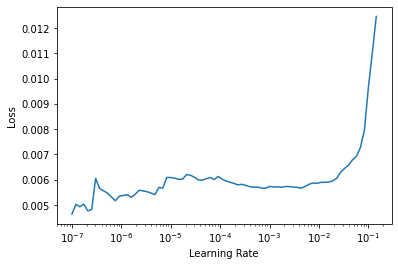

In [23]:
learn.lr_find()

In [24]:
wd=1e-2
lr=1e-8

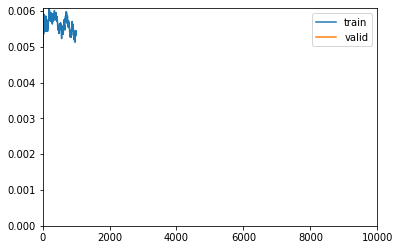

In [ ]:
learn.unfreeze()
lrs=slice(1e-8, 1e-5)
learn.fit_one_cycle(10, lrs, pct_start=0.8, wd=wd)

learn.recorder.plot_metrics()

learn.recorder.plot_loss()

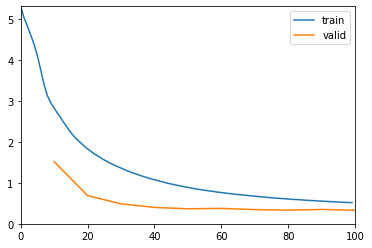

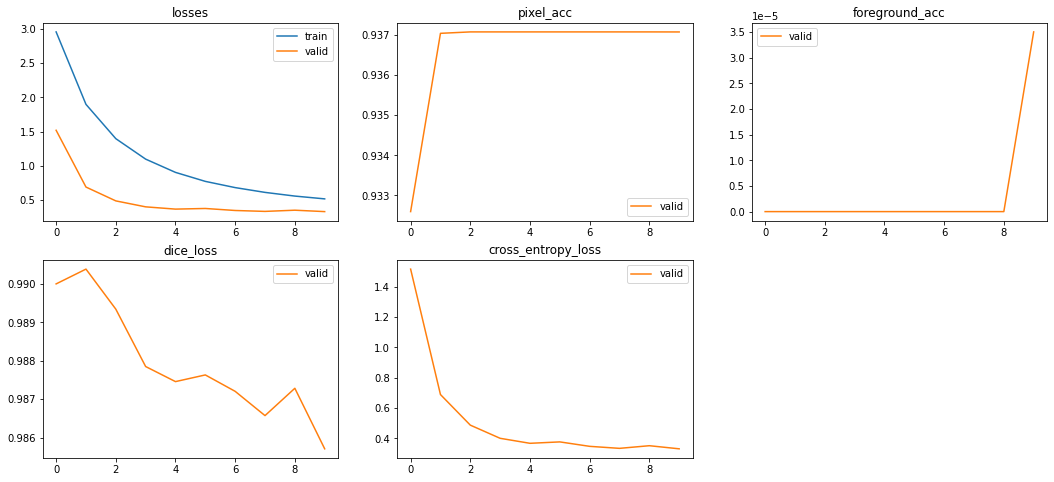

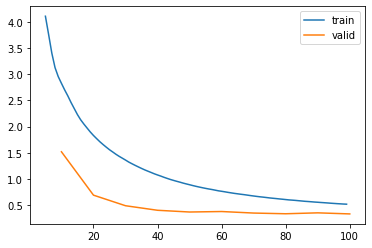

In [28]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=wd)

learn.recorder.plot_metrics()

learn.recorder.plot_loss()

In [ ]:
learn.unfreeze()
lrs=slice(1e-7, 1e-5)
learn.fit_one_cycle(10, lrs, pct_start=0.8, wd=wd)

learn.recorder.plot_metrics()

learn.recorder.plot_loss()

In [28]:
learn.save('stage-0504-1')

In [22]:
learn.load('stage-0504-1')

In [23]:
learn.load('stage-2-4')

In [197]:
learn.load('stage-2')

# Show Results

In [188]:
def shapes(arg):
    if hasattr(arg, 'shape'):
        return arg.shape
    elif isinstance(arg, tuple):
        return [shapes(t) for t in arg]

from math import sqrt, ceil
def get_rows_cols(n, cols=None, rows=None):
    if rows is not None and cols is not None:
        raise RuntimeError("Cannot specify both")
    if rows is not None and cols is None:
        cols = ceil(n / rows)
    elif cols is not None and rows is None:
        rows = ceil(n / cols)
    else:
        rows = int(sqrt(n))
        cols = ceil(n / rows)
    return (rows, cols)

# get_rows_cols(4)
# get_rows_cols(4, cols=1)
# get_rows_cols(4, rows=1)

from typing import Literal, Tuple
def show_results(lrn, max_n: int, figsize: Tuple[int, int], ds_idx: Literal[0, 1] = 1):
    b = learn.dls[ds_idx].new(shuffle=True).one_batch()
    preds, targets = learn.get_preds(dl=[b])
    inps = b[0][:max_n].cpu()
    preds = preds[:max_n]
    targets = targets[:max_n]
    nrows, ncols = preds.shape[0], 4
    fig, axs = get_grid(nrows * ncols, nrows=nrows, ncols=ncols, imsize=figsize[0], return_fig=True, title="Prediction/Target/Diff")
    for i, (inp, pred, target) in enumerate(zip(inps, preds, targets)):
        pred = pred.argmax(dim=0)
        show_npimg(np.transpose(np.array(inp), (1, 2, 0)), fig_ax=(fig, axs[ncols*i]))
        show_npimg(pred, fig_ax=(fig, axs[ncols*i + 1]), cmap=glasbey_cm)
        show_npimg(target, fig_ax=(fig, axs[ncols*i + 2]), cmap=glasbey_cm)
        diff = target
        diff[pred == target] = 0
        show_npimg(diff, fig_ax=(fig, axs[ncols*i + 3]), cmap=glasbey_cm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


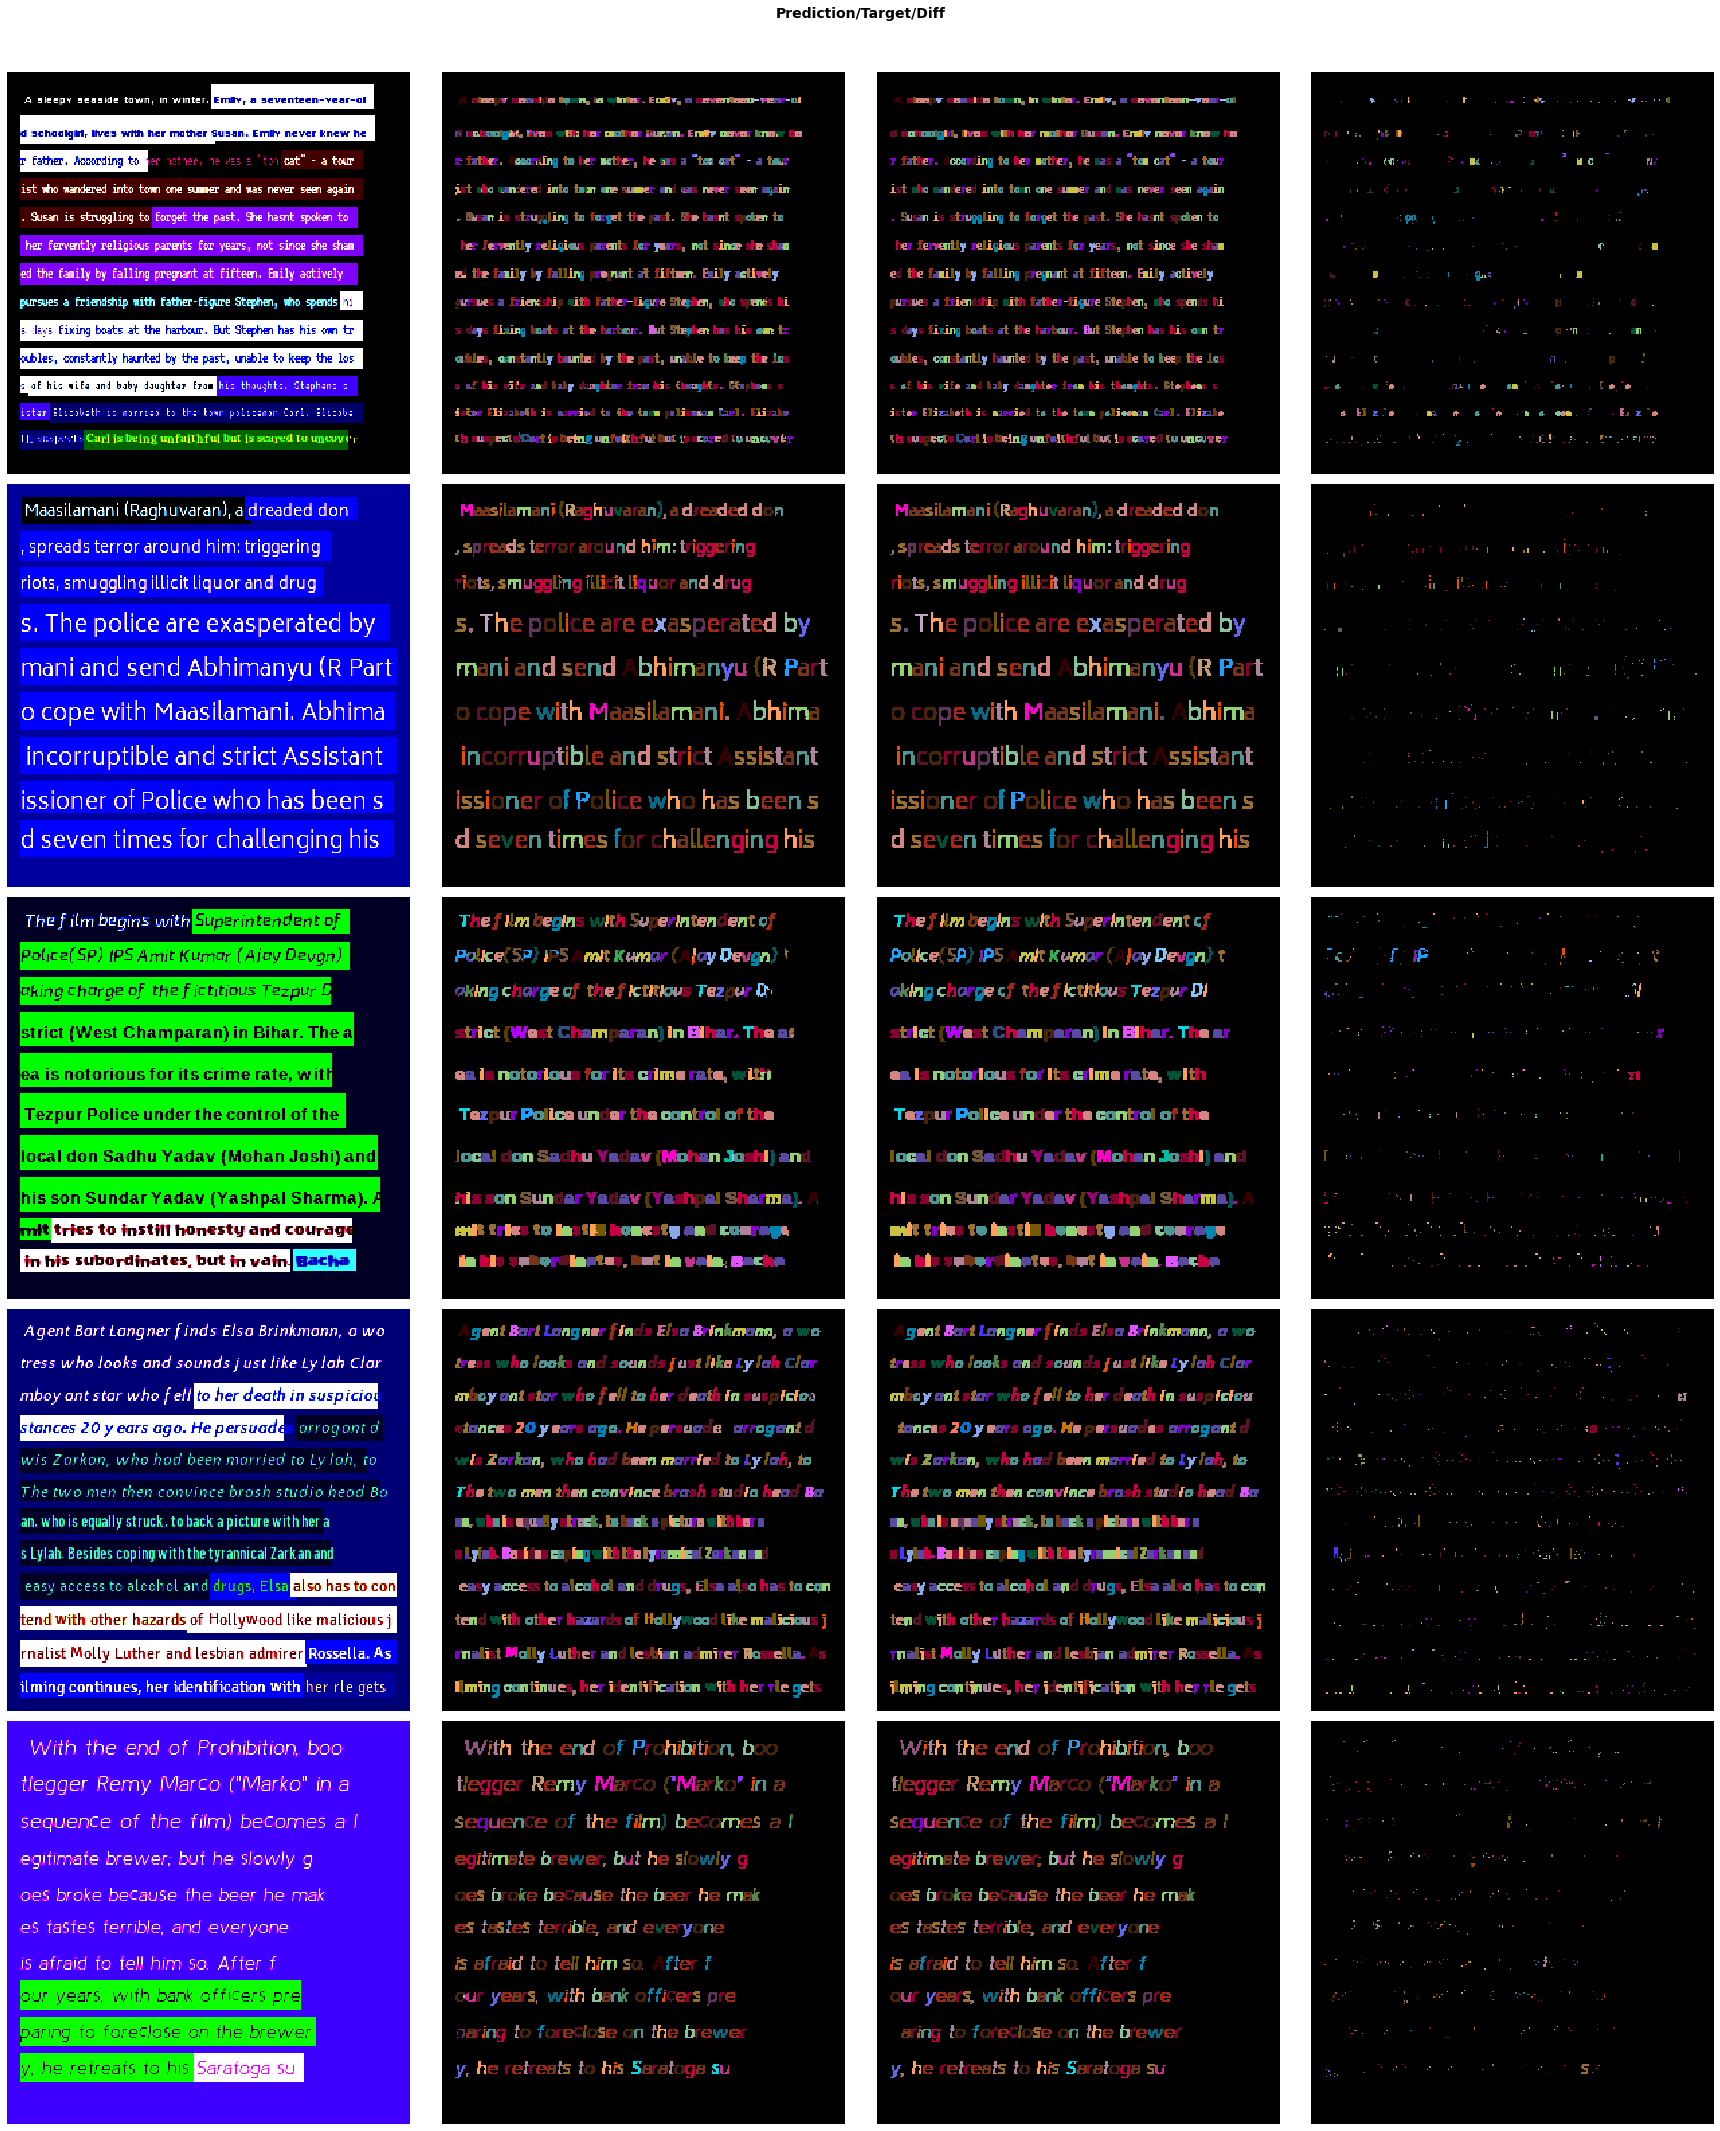

In [194]:
show_results(learn, 5, figsize=(6,6))